In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import numpy as np
import itertools

print(os.getcwd())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

df_train = pd.read_csv("../codeT5/train_data.csv")
df_test = pd.read_csv("../codeT5/test_data.csv")

X_train = torch.load("../codeT5/X_train.pt", weights_only=False)
X_test = torch.load("../codeT5/X_test.pt", weights_only=False)

def process_vulnerability_list(vuln_list_series, num_classes=9):
    vuln_lists = vuln_list_series.apply(ast.literal_eval)
    y_binary = np.array([np.array(vuln) for vuln in vuln_lists], dtype=np.float32)
    if y_binary.shape[1] != num_classes:
        raise ValueError(f"Expected {num_classes} dimensions, got {y_binary.shape[1]}")
    return torch.tensor(y_binary, dtype=torch.float32)

y_train = process_vulnerability_list(df_train['vulnerability_list'], num_classes=9)
y_test = process_vulnerability_list(df_test['vulnerability_list'], num_classes=9)

torch.save(y_train, "../codeT5/y_train.pt")
torch.save(y_test, "../codeT5/y_test.pt")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

/Users/rita/Documents/9309_ML/Smart_Contract_Vulnerabilities_Project/Model Training
Training on device: mps
X_train shape: torch.Size([4294, 768])
y_train shape: torch.Size([4294, 9])
X_test shape: torch.Size([1074, 768])
y_test shape: torch.Size([1074, 9])


In [ ]:
class VulnScreener(nn.Module):
    def __init__(self):
        super(VulnScreener, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(768, 256),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),    
            nn.Sigmoid()          
        )
    
    def forward(self, x):
        return self.mlp(x)  
        
screener = torch.load('../codeT5/vuln_screener_model.pth', weights_only=False)
screener.to(device)
screener.eval()
with torch.no_grad():
    train_prob = screener(X_train.to(device))
    test_prob = screener(X_test.to(device))

def oversample_rare_classes(X, p_s, y, class_indices=[1, 2, 3, 4, 5, 7]):
    mask_123 = torch.any(y[:, [1, 2, 3]] == 1, dim=1)
    mask_457 = torch.any(y[:, [4, 5, 7]] == 1, dim=1)
    X_rare_123 = X[mask_123]
    p_s_rare_123 = p_s[mask_123]
    y_rare_123 = y[mask_123]
    X_rare_457 = X[mask_457]
    p_s_rare_457 = p_s[mask_457]
    y_rare_457 = y[mask_457]
    X = torch.cat([X] + [X_rare_123] * 5 + [X_rare_457] * 8, dim=0)
    p_s = torch.cat([p_s] + [p_s_rare_123] * 5 + [p_s_rare_457] * 8, dim=0)
    y = torch.cat([y] + [y_rare_123] * 5 + [y_rare_457] * 8, dim=0)
    return X, p_s, y
    
X_train, train_prob, y_train = oversample_rare_classes(X_train, train_prob, y_train)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha if alpha is not None else torch.ones(9).to(device)
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

class VulnAnalyzer(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(VulnAnalyzer, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(769, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(384, 9),
            nn.Sigmoid()
        )
    
    def forward(self, x, p_s):
        if p_s.dim() == 1:
            p_s = p_s.unsqueeze(1)
        x = torch.cat((x, p_s), dim=1)
        return self.network(x), None  

def train_vuln_analyzer(X_train, p_s_train, y_train, threshold=0.5, epochs=150, lr=0.001, 
                       dropout_rate=0.4, weight_decay=0.01, validator_feedback=None):
    model = VulnAnalyzer(dropout_rate=dropout_rate).to(device)
    
    alpha = torch.tensor([1.0, 1.0, 1.5, 1.5, 2.0, 2.5, 1.0, 2.5, 1.0]).to(device)
    criterion = FocalLoss(alpha=alpha, gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    X_train, p_s_train, y_train = X_train.to(device), p_s_train.to(device), y_train.to(device)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        mask = p_s_train > threshold
        X_train_filtered = X_train[mask.squeeze()]
        p_s_train_filtered = p_s_train[mask]
        y_train_filtered = y_train[mask.squeeze()]
        
        if len(X_train_filtered) == 0:
            threshold = 0.5  
            mask = p_s_train > threshold
            X_train_filtered = X_train[mask.squeeze()]
            p_s_train_filtered = p_s_train[mask]
            y_train_filtered = y_train[mask.squeeze()]
        
        p_a, _ = model(X_train_filtered, p_s_train_filtered)
        loss = criterion(p_a, y_train_filtered)
        
        with torch.no_grad():
            y_pred_binary = (p_a > 0.5).float()
            train_f1 = f1_score(y_train_filtered.cpu(), y_pred_binary.cpu(), average='micro')
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        if validator_feedback is not None and epoch % 10 == 0 and epoch > 0:
            with torch.no_grad():
                for vuln_idx, correction_factor in validator_feedback.items():
                    if vuln_idx < 9 and correction_factor > 0:
                        model.network[-2].weight[vuln_idx] *= (1 + correction_factor * 0.1)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Train F1: {train_f1:.4f}, Threshold: {threshold:.3f}")
    
    return model

def test_vuln_analyzer(model, X_test, p_s_test, y_test, detailed_report=True):
    model.eval()
    X_test, p_s_test, y_test = X_test.to(device), p_s_test.to(device), y_test.to(device)
    
    with torch.no_grad():
        p_a, attn_weights = model(X_test, p_s_test)
        y_pred_proba = p_a.cpu().numpy()
        y_true = y_test.cpu().numpy()
    
    metrics = {}
    n_classes = y_true.shape[1]
    optimal_thresholds = []
    
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
        f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)
        plt.plot(recall, precision, label=f'Class {i} (Opt. Threshold: {optimal_threshold:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        auc_score = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC: {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    y_pred_binary = np.zeros_like(y_pred_proba)
    for i in range(n_classes):
        y_pred_binary[:, i] = (y_pred_proba[:, i] >= optimal_thresholds[i]).astype(int)
    
    metrics['avg_precision'] = precision_score(y_true, y_pred_binary, average='micro')
    metrics['avg_recall'] = recall_score(y_true, y_pred_binary, average='micro')
    metrics['avg_f1'] = f1_score(y_true, y_pred_binary, average='micro')
    metrics['avg_auc'] = roc_auc_score(y_true, y_pred_proba, average='micro')
    metrics['optimal_thresholds'] = optimal_thresholds
    
    class_metrics = {
        'precision': precision_score(y_true, y_pred_binary, average=None, zero_division=0),
        'recall': recall_score(y_true, y_pred_binary, average=None),
        'f1': f1_score(y_true, y_pred_binary, average=None),
        'auc': [roc_auc_score(y_true[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
    }
    metrics['class_metrics'] = class_metrics
    
    plt.figure(figsize=(15, 15))
    for i in range(n_classes):
        cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
        plt.subplot(3, 3, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Class {i} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    print("\n=== VulnAnalyzer Test Results (Optimal Thresholds) ===")
    print(f"Test Samples: {len(X_test)}")
    print(f"Average Precision: {metrics['avg_precision']:.4f}")
    print(f"Average Recall: {metrics['avg_recall']:.4f}")
    print(f"Average F1-Score: {metrics['avg_f1']:.4f}")
    print(f"Average AUC: {metrics['avg_auc']:.4f}")
    
    if detailed_report:
        print("\nPer-Class Metrics with Optimal Thresholds:")
        for i in range(n_classes):
            print(f"\nVulnerability {i} (Threshold: {optimal_thresholds[i]:.3f}):")
            print(f"Precision: {class_metrics['precision'][i]:.4f}")
            print(f"Recall: {class_metrics['recall'][i]:.4f}")
            print(f"F1-Score: {class_metrics['f1'][i]:.4f}")
            print(f"AUC: {class_metrics['auc'][i]:.4f}")
    
    return metrics, y_pred_proba, attn_weights

Epoch 0, Loss: 0.3535, Train F1: 0.1741, Threshold: 0.500
Epoch 10, Loss: 0.1226, Train F1: 0.5149, Threshold: 0.500
Epoch 20, Loss: 0.0889, Train F1: 0.6776, Threshold: 0.500
Epoch 30, Loss: 0.0639, Train F1: 0.7730, Threshold: 0.500
Epoch 40, Loss: 0.0444, Train F1: 0.8535, Threshold: 0.500
Epoch 50, Loss: 0.0299, Train F1: 0.9014, Threshold: 0.500
Epoch 60, Loss: 0.0215, Train F1: 0.9317, Threshold: 0.500
Epoch 70, Loss: 0.0165, Train F1: 0.9484, Threshold: 0.500
Epoch 80, Loss: 0.0134, Train F1: 0.9592, Threshold: 0.500
Epoch 90, Loss: 0.0116, Train F1: 0.9660, Threshold: 0.500
Epoch 100, Loss: 0.0102, Train F1: 0.9713, Threshold: 0.500
Epoch 110, Loss: 0.0095, Train F1: 0.9747, Threshold: 0.500
Epoch 120, Loss: 0.0091, Train F1: 0.9747, Threshold: 0.500
Epoch 130, Loss: 0.0089, Train F1: 0.9769, Threshold: 0.500
Epoch 140, Loss: 0.0086, Train F1: 0.9766, Threshold: 0.500


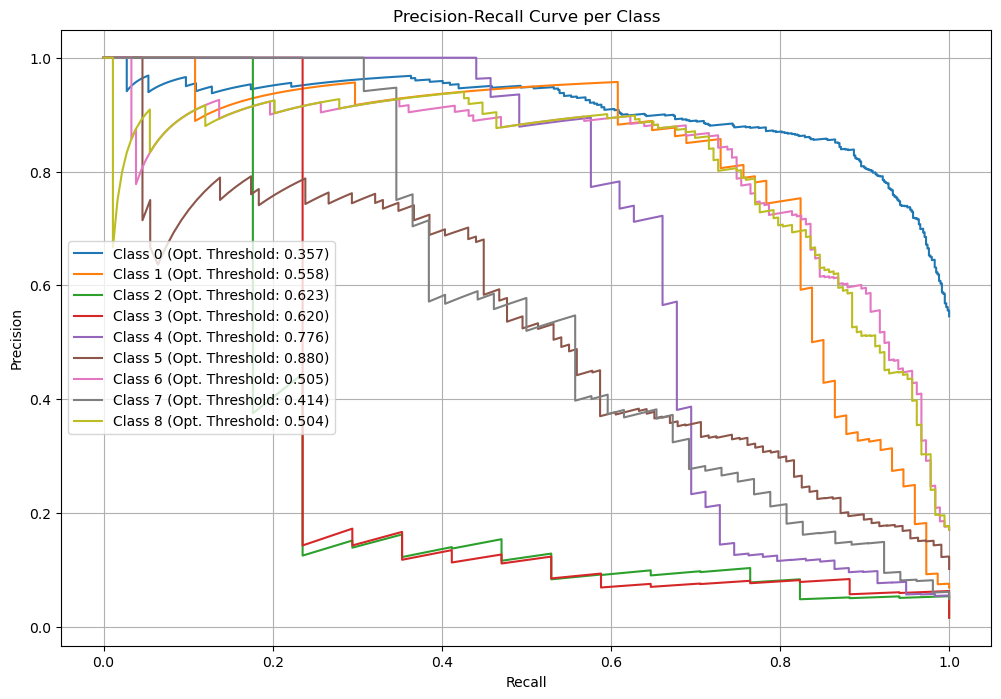

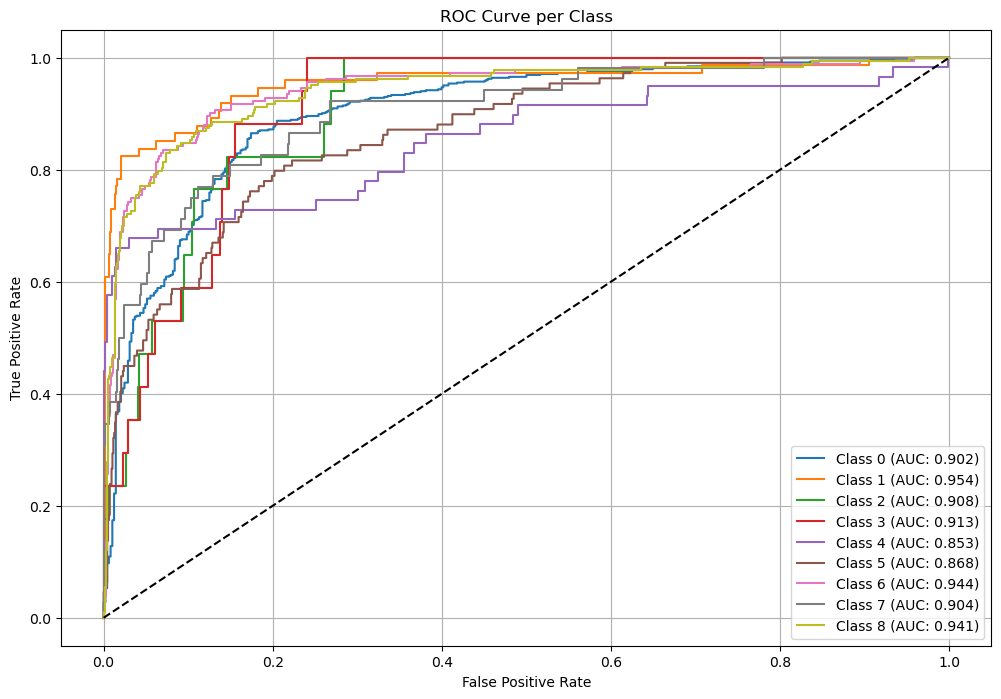

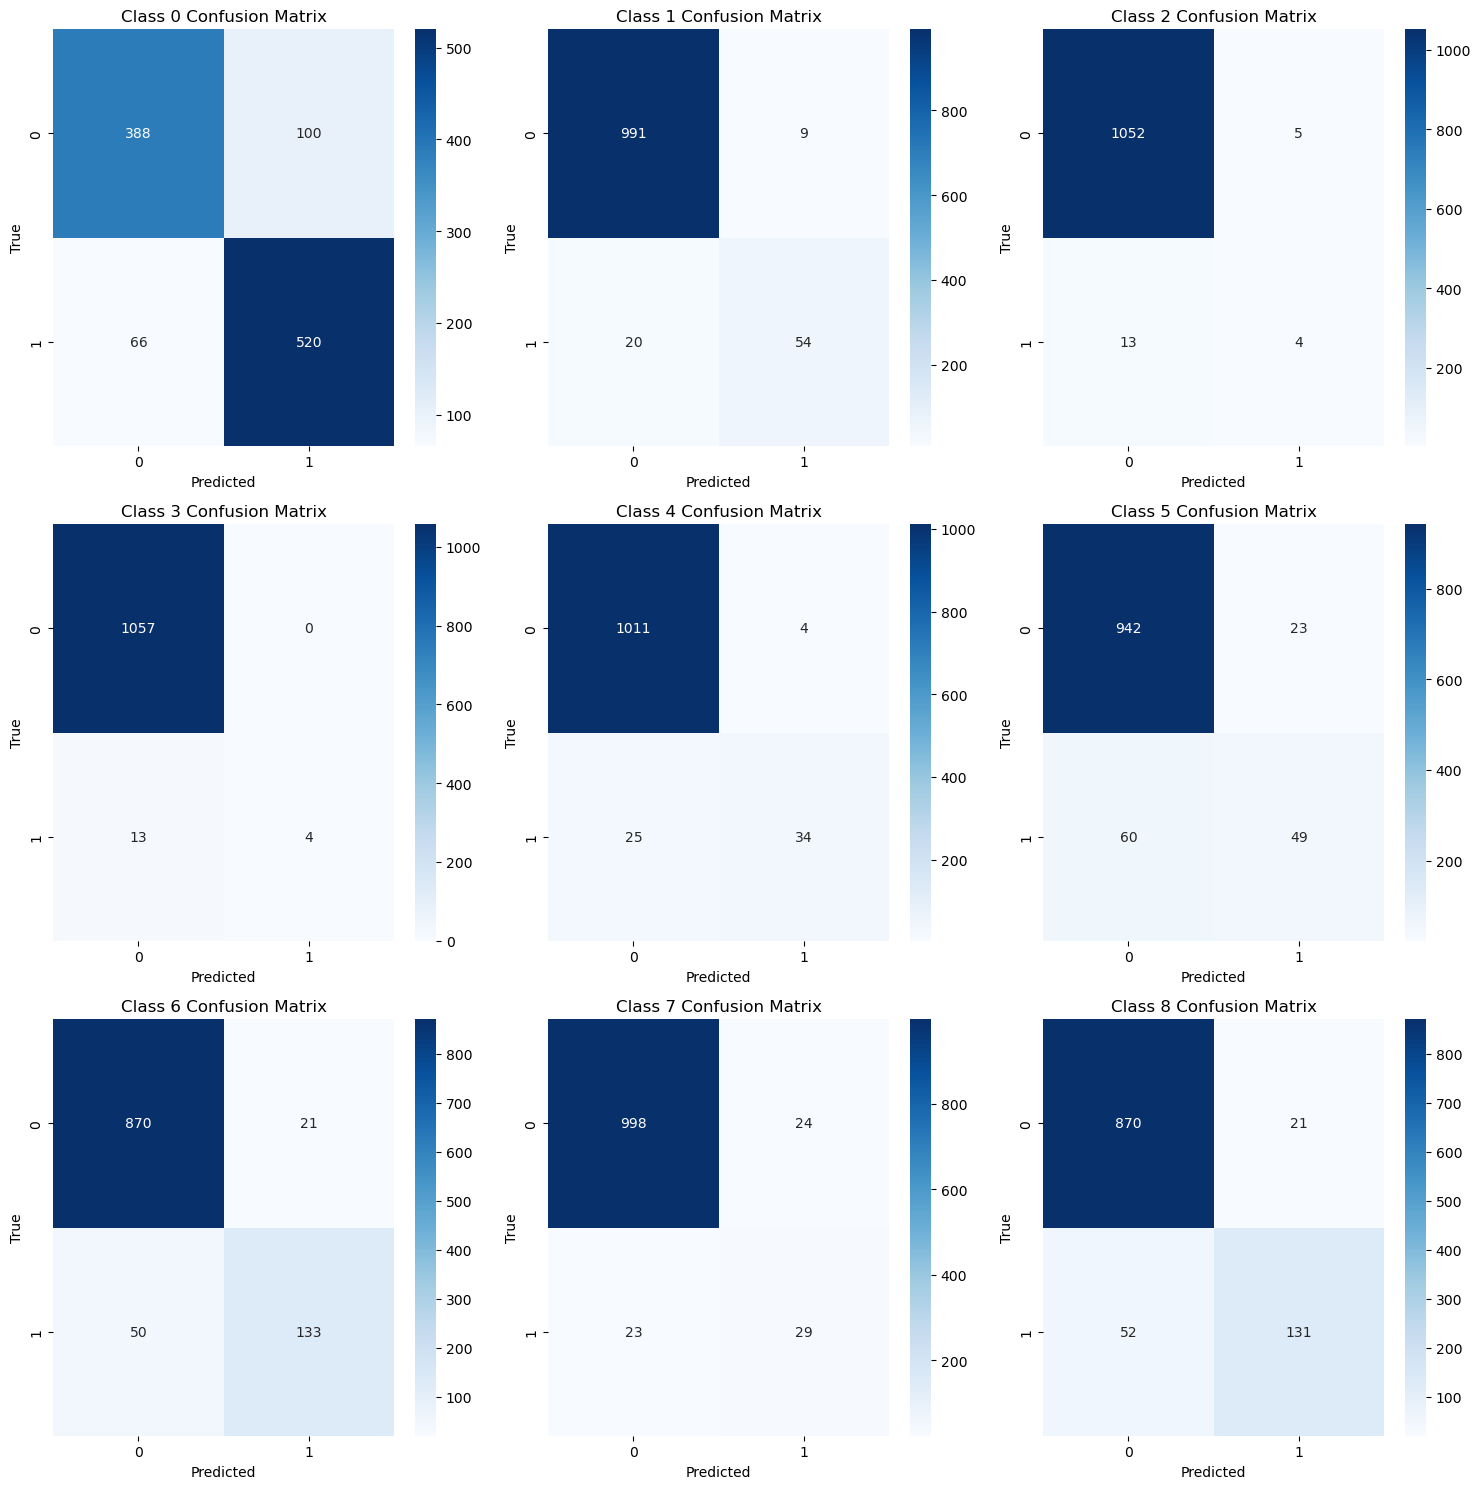


=== VulnAnalyzer Test Results (Optimal Thresholds) ===
Test Samples: 1074
Average Precision: 0.8223
Average Recall: 0.7484
Average F1-Score: 0.7836
Average AUC: 0.9190

Per-Class Metrics with Optimal Thresholds:

Vulnerability 0 (Threshold: 0.357):
Precision: 0.8387
Recall: 0.8874
F1-Score: 0.8624
AUC: 0.9021

Vulnerability 1 (Threshold: 0.558):
Precision: 0.8571
Recall: 0.7297
F1-Score: 0.7883
AUC: 0.9537

Vulnerability 2 (Threshold: 0.623):
Precision: 0.4444
Recall: 0.2353
F1-Score: 0.3077
AUC: 0.9082

Vulnerability 3 (Threshold: 0.620):
Precision: 1.0000
Recall: 0.2353
F1-Score: 0.3810
AUC: 0.9128

Vulnerability 4 (Threshold: 0.776):
Precision: 0.8947
Recall: 0.5763
F1-Score: 0.7010
AUC: 0.8531

Vulnerability 5 (Threshold: 0.880):
Precision: 0.6806
Recall: 0.4495
F1-Score: 0.5414
AUC: 0.8682

Vulnerability 6 (Threshold: 0.505):
Precision: 0.8636
Recall: 0.7268
F1-Score: 0.7893
AUC: 0.9442

Vulnerability 7 (Threshold: 0.414):
Precision: 0.5472
Recall: 0.5577
F1-Score: 0.5524
AUC: 0.

In [ ]:
best_params = {'lr': 0.001, 'dropout_rate': 0.4, 'weight_decay': 0.01}
validator_feedback = {0: 0.5, 2: 0.3}

final_model = train_vuln_analyzer(
    X_train, train_prob, y_train,
    threshold=0.5, epochs=150, **best_params, validator_feedback=validator_feedback
)
metrics, probabilities, attn_weights = test_vuln_analyzer(final_model, X_test, test_prob, y_test)

print("\nSample Probabilities (first 5):", probabilities[:5])
print("Attention Weights Shape:", attn_weights.shape if attn_weights is not None else "None (MLP)")